# Комплексное решение задачи классификации диабета

В данном ноутбуке представлено комплексное решение задачи классификации диабета с использованием:
- Основных алгоритмов машинного обучения
- Ансамблевых методов
- Современных подходов
- Полной оценки через всевозможные метрики


## Импорт библиотек


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Метрики
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

# Разделение данных
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Основные алгоритмы
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    AdaBoostClassifier, ExtraTreesClassifier,
    VotingClassifier, StackingClassifier,
    HistGradientBoostingClassifier
)

# Современные библиотеки
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost не установлен")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM не установлен")

try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("CatBoost не установлен")

print("Библиотеки успешно импортированы!")


CatBoost не установлен
Библиотеки успешно импортированы!


## Загрузка предобработанных данных


In [2]:
# Загрузка данных
X_train = pd.read_csv('../data/processed/diabetes_train_proc.csv')
X_test = pd.read_csv('../data/processed/diabetes_test_proc.csv')

# Разделение на признаки и целевую переменную
y_train = X_train['Outcome']
y_test = X_test['Outcome']
X_train = X_train.drop('Outcome', axis=1)
X_test = X_test.drop('Outcome', axis=1)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts())
print(f"\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts())


Размер обучающей выборки: (576, 14)
Размер тестовой выборки: (192, 14)

Распределение классов в обучающей выборке:
Outcome
0    375
1    201
Name: count, dtype: int64

Распределение классов в тестовой выборке:
Outcome
0    125
1     67
Name: count, dtype: int64


## Функции для оценки моделей


In [3]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Полная оценка модели через всевозможные метрики
    """
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказания
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Проверяем наличие predict_proba
    has_proba = hasattr(model, 'predict_proba')
    
    if has_proba:
        try:
            y_train_proba = model.predict_proba(X_train)[:, 1]
            y_test_proba = model.predict_proba(X_test)[:, 1]
        except AttributeError:
            # Если predict_proba есть, но не работает (например, для hard voting)
            has_proba = False
            y_train_proba = None
            y_test_proba = None
    else:
        y_train_proba = None
        y_test_proba = None
    
    # Метрики для обучающей выборки
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'f1': f1_score(y_train, y_train_pred),
    }
    
    # Метрики для тестовой выборки
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
    }
    
    # Добавляем метрики, требующие вероятности (если доступны)
    if has_proba and y_train_proba is not None:
        train_metrics['roc_auc'] = roc_auc_score(y_train, y_train_proba)
        train_metrics['pr_auc'] = average_precision_score(y_train, y_train_proba)
        test_metrics['roc_auc'] = roc_auc_score(y_test, y_test_proba)
        test_metrics['pr_auc'] = average_precision_score(y_test, y_test_proba)
    else:
        # Для моделей без predict_proba устанавливаем None
        train_metrics['roc_auc'] = None
        train_metrics['pr_auc'] = None
        test_metrics['roc_auc'] = None
        test_metrics['pr_auc'] = None
        y_test_proba = np.zeros_like(y_test_pred, dtype=float)  # Заглушка для визуализации
    
    # Confusion matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    
    return {
        'model_name': model_name,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'cm_train': cm_train,
        'cm_test': cm_test,
        'y_test_proba': y_test_proba,
        'y_test_pred': y_test_pred,
        'model': model,
        'has_proba': has_proba
    }

def plot_confusion_matrix(cm, title, ax):
    """Визуализация confusion matrix"""
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Истинные значения')
    ax.set_xlabel('Предсказанные значения')

def plot_roc_curves(results_dict, ax):
    """Визуализация ROC кривых"""
    for name, result in results_dict.items():
        # Пропускаем модели без predict_proba
        if result.get('has_proba', True) and result['test_metrics'].get('roc_auc') is not None:
            fpr, tpr, _ = roc_curve(y_test, result['y_test_proba'])
            ax.plot(fpr, tpr, label=f"{name} (AUC = {result['test_metrics']['roc_auc']:.3f})")
    ax.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC кривые')
    ax.legend()
    ax.grid(True)

def plot_pr_curves(results_dict, ax):
    """Визуализация Precision-Recall кривых"""
    for name, result in results_dict.items():
        # Пропускаем модели без predict_proba
        if result.get('has_proba', True) and result['test_metrics'].get('pr_auc') is not None:
            precision, recall, _ = precision_recall_curve(y_test, result['y_test_proba'])
            ax.plot(recall, precision, label=f"{name} (PR-AUC = {result['test_metrics']['pr_auc']:.3f})")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall кривые')
    ax.legend()
    ax.grid(True)

print("Функции для оценки моделей созданы!")


Функции для оценки моделей созданы!


## 1. Основные алгоритмы машинного обучения


In [4]:
# Словарь для хранения результатов
results = {}

# 1. Логистическая регрессия
print("Обучение логистической регрессии...")
lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
results['Logistic Regression'] = evaluate_model(lr, X_train, y_train, X_test, y_test, 'Logistic Regression')

# 2. SVM
print("Обучение SVM...")
svm = SVC(probability=True, random_state=42, class_weight='balanced')
results['SVM'] = evaluate_model(svm, X_train, y_train, X_test, y_test, 'SVM')

# 3. KNN
print("Обучение KNN...")
knn = KNeighborsClassifier(n_neighbors=5)
results['KNN'] = evaluate_model(knn, X_train, y_train, X_test, y_test, 'KNN')

# 4. Decision Tree
print("Обучение Decision Tree...")
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=10)
results['Decision Tree'] = evaluate_model(dt, X_train, y_train, X_test, y_test, 'Decision Tree')

print("Основные алгоритмы обучены!")


Обучение логистической регрессии...
Обучение SVM...
Обучение KNN...
Обучение Decision Tree...
Основные алгоритмы обучены!


## 2. Ансамблевые методы (Bagging и Boosting)


In [5]:
# 5. Random Forest
print("Обучение Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
results['Random Forest'] = evaluate_model(rf, X_train, y_train, X_test, y_test, 'Random Forest')

# 6. Gradient Boosting
print("Обучение Gradient Boosting...")
gb = GradientBoostingClassifier(n_estimators=100, random_state=42, learning_rate=0.1)
results['Gradient Boosting'] = evaluate_model(gb, X_train, y_train, X_test, y_test, 'Gradient Boosting')

# 7. AdaBoost
print("Обучение AdaBoost...")
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
results['AdaBoost'] = evaluate_model(ada, X_train, y_train, X_test, y_test, 'AdaBoost')

# 8. Extra Trees
print("Обучение Extra Trees...")
et = ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
results['Extra Trees'] = evaluate_model(et, X_train, y_train, X_test, y_test, 'Extra Trees')

# 9. Histogram-based Gradient Boosting
print("Обучение HistGradientBoosting...")
hgb = HistGradientBoostingClassifier(random_state=42, max_iter=100)
results['HistGradientBoosting'] = evaluate_model(hgb, X_train, y_train, X_test, y_test, 'HistGradientBoosting')

print("Ансамблевые методы обучены!")


Обучение Random Forest...
Обучение Gradient Boosting...
Обучение AdaBoost...
Обучение Extra Trees...
Обучение HistGradientBoosting...
Ансамблевые методы обучены!


## 3. Современные библиотеки (XGBoost, LightGBM, CatBoost)


In [6]:
# 10. XGBoost
if XGBOOST_AVAILABLE:
    print("Обучение XGBoost...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )
    results['XGBoost'] = evaluate_model(xgb_model, X_train, y_train, X_test, y_test, 'XGBoost')
else:
    print("XGBoost пропущен (не установлен)")

# 11. LightGBM
if LIGHTGBM_AVAILABLE:
    print("Обучение LightGBM...")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        verbose=-1
    )
    results['LightGBM'] = evaluate_model(lgb_model, X_train, y_train, X_test, y_test, 'LightGBM')
else:
    print("LightGBM пропущен (не установлен)")

# 12. CatBoost
if CATBOOST_AVAILABLE:
    print("Обучение CatBoost...")
    cat_model = CatBoostClassifier(
        iterations=100,
        random_state=42,
        verbose=False,
        class_weights=[1, (y_train == 0).sum() / (y_train == 1).sum()]
    )
    results['CatBoost'] = evaluate_model(cat_model, X_train, y_train, X_test, y_test, 'CatBoost')
else:
    print("CatBoost пропущен (не установлен)")

print("Современные библиотеки обучены!")


Обучение XGBoost...
Обучение LightGBM...
CatBoost пропущен (не установлен)
Современные библиотеки обучены!


## 4. Продвинутые ансамблевые методы


In [7]:
# Выбираем лучшие базовые модели для ансамблей
best_models = []
if 'Random Forest' in results:
    best_models.append(('rf', results['Random Forest']['model']))
if 'Gradient Boosting' in results:
    best_models.append(('gb', results['Gradient Boosting']['model']))
if 'XGBoost' in results:
    best_models.append(('xgb', results['XGBoost']['model']))
if 'LightGBM' in results:
    best_models.append(('lgb', results['LightGBM']['model']))
if 'CatBoost' in results:
    best_models.append(('cat', results['CatBoost']['model']))
if 'Extra Trees' in results:
    best_models.append(('et', results['Extra Trees']['model']))

# Если нет современных библиотек, используем доступные
if len(best_models) < 3:
    best_models = [
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('et', ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1))
    ]

# 13. Voting Classifier (Hard Voting)
print("Обучение Voting Classifier (Hard)...")
voting_hard = VotingClassifier(estimators=best_models[:3], voting='hard')
results['Voting (Hard)'] = evaluate_model(voting_hard, X_train, y_train, X_test, y_test, 'Voting (Hard)')

# 14. Voting Classifier (Soft Voting)
print("Обучение Voting Classifier (Soft)...")
voting_soft = VotingClassifier(estimators=best_models[:3], voting='soft')
results['Voting (Soft)'] = evaluate_model(voting_soft, X_train, y_train, X_test, y_test, 'Voting (Soft)')

# 15. Stacking Classifier
print("Обучение Stacking Classifier...")
stacking = StackingClassifier(
    estimators=best_models[:3],
    final_estimator=LogisticRegression(random_state=42, class_weight='balanced'),
    cv=5
)
results['Stacking'] = evaluate_model(stacking, X_train, y_train, X_test, y_test, 'Stacking')

print("Продвинутые ансамбли обучены!")


Обучение Voting Classifier (Hard)...
Обучение Voting Classifier (Soft)...
Обучение Stacking Classifier...
Продвинутые ансамбли обучены!


## 5. Сводная таблица результатов


In [8]:
# Создание сводной таблицы
summary_data = []
for name, result in results.items():
    roc_auc = result['test_metrics'].get('roc_auc')
    pr_auc = result['test_metrics'].get('pr_auc')
    summary_data.append({
        'Model': name,
        'Train Accuracy': f"{result['train_metrics']['accuracy']:.4f}",
        'Test Accuracy': f"{result['test_metrics']['accuracy']:.4f}",
        'Test Precision': f"{result['test_metrics']['precision']:.4f}",
        'Test Recall': f"{result['test_metrics']['recall']:.4f}",
        'Test F1': f"{result['test_metrics']['f1']:.4f}",
        'Test ROC-AUC': f"{roc_auc:.4f}" if roc_auc is not None else "N/A",
        'Test PR-AUC': f"{pr_auc:.4f}" if pr_auc is not None else "N/A"
    })

summary_df = pd.DataFrame(summary_data)
# Сортируем по ROC-AUC, но модели без ROC-AUC идут в конец
summary_df['Sort_ROC'] = summary_df['Test ROC-AUC'].apply(lambda x: float(x) if x != 'N/A' else -1)
summary_df = summary_df.sort_values('Sort_ROC', ascending=False).drop('Sort_ROC', axis=1)
display(summary_df)


,Model,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC-AUC,Test PR-AUC
1,SVM,0.8108,0.7396,0.5955,0.7910,0.6795,0.8562,0.7536
12,Voting (Soft),1.0000,0.7604,0.6479,0.6866,0.6667,0.8501,0.7487
4,Random Forest,1.0000,0.7760,0.7000,0.6269,0.6614,0.8494,0.7419
13,Stacking,0.9479,0.7396,0.6000,0.7612,0.6711,0.8453,0.7372
0,Logistic Regression,0.7691,0.7344,0.5930,0.7612,0.6667,0.8359,0.6923
7,Extra Trees,1.0000,0.7552,0.6429,0.6716,0.6569,0.8359,0.6886
6,AdaBoost,0.7969,0.7396,0.6164,0.6716,0.6429,0.8349,0.6775
5,Gradient Boosting,0.9288,0.7656,0.6774,0.6269,0.6512,0.8318,0.6914
8,HistGradientBoosting,1.0000,0.7552,0.6515,0.6418,0.6466,0.8259,0.7382
10,LightGBM,0.9983,0.7396,0.6164,0.6716,0.6429,0.8242,0.7254


## 6. Визуализация метрик


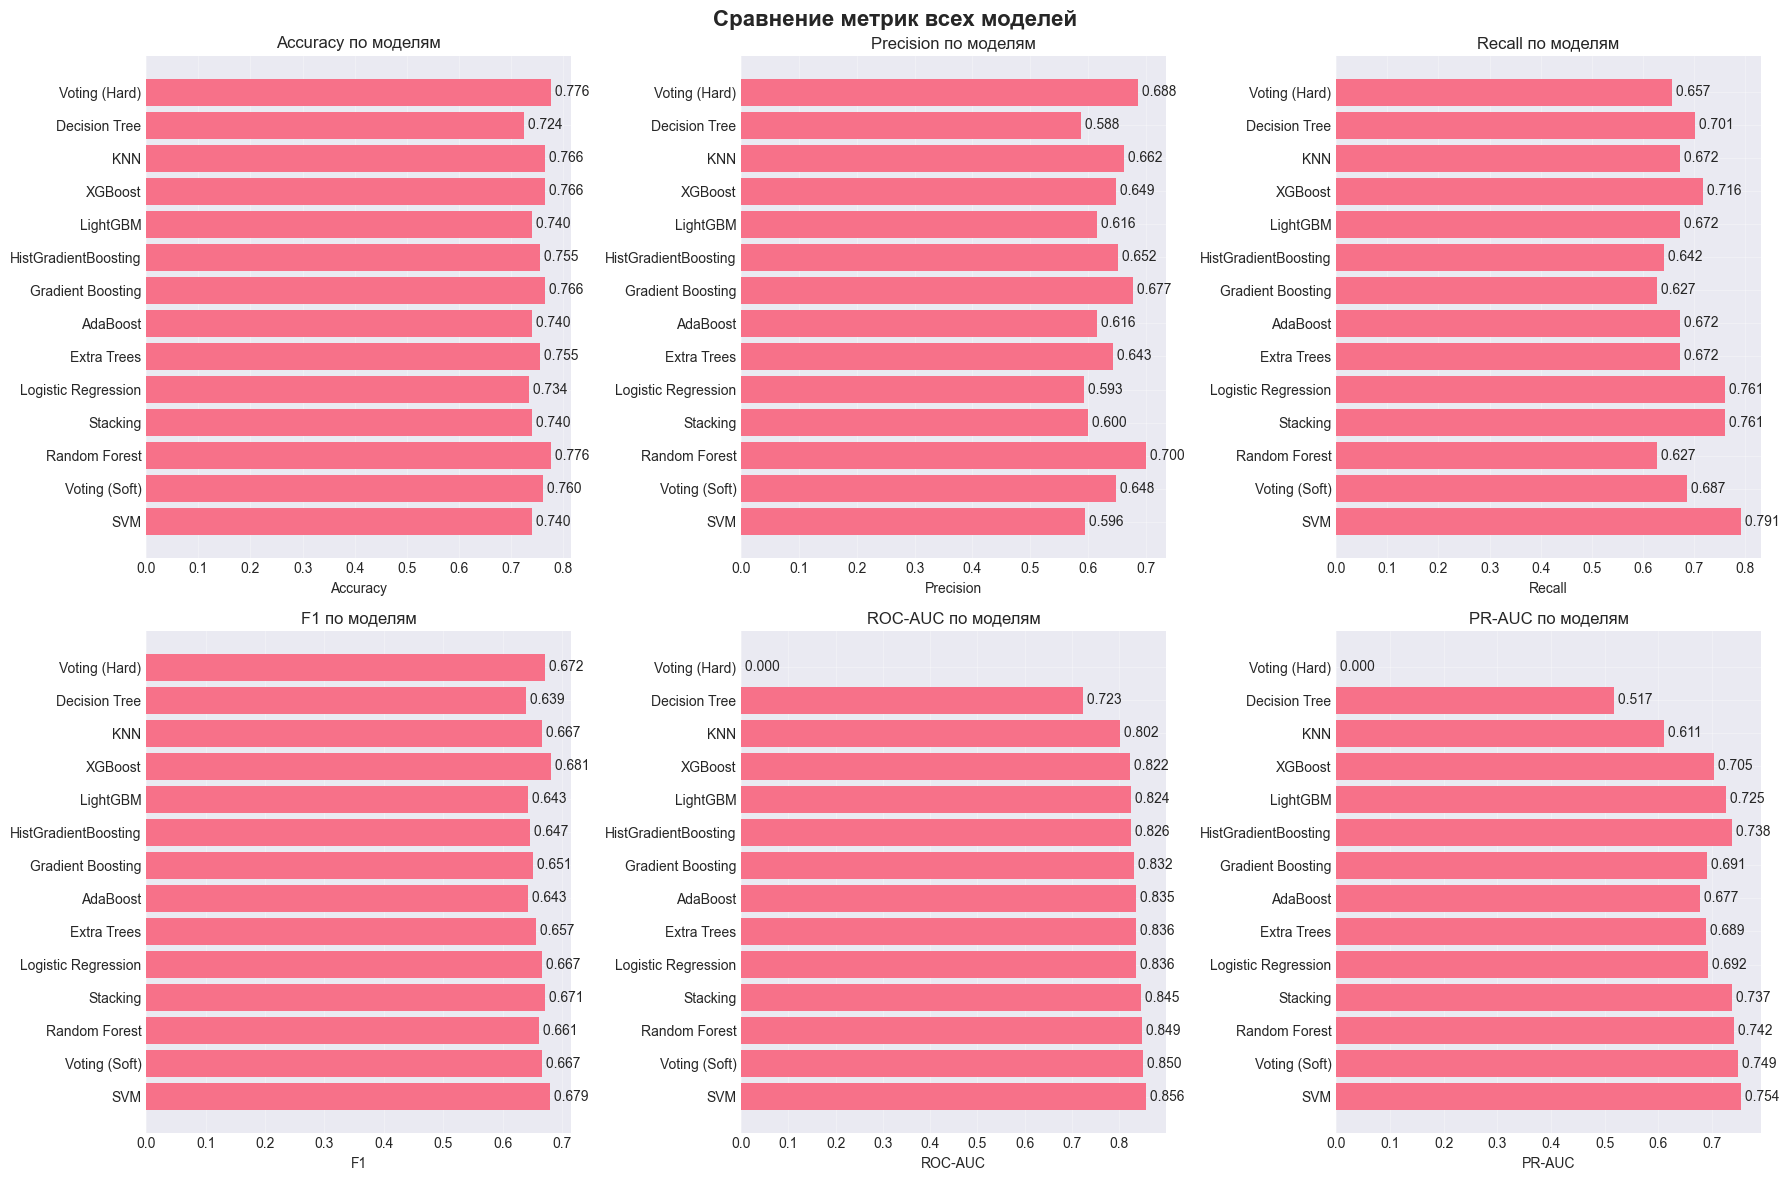

In [9]:
# Подготовка данных для визуализации
metrics_data = []
for name, result in results.items():
    roc_auc = result['test_metrics'].get('roc_auc', 0)
    pr_auc = result['test_metrics'].get('pr_auc', 0)
    # Если метрика None, используем 0 для сортировки
    metrics_data.append({
        'Model': name,
        'Accuracy': result['test_metrics']['accuracy'],
        'Precision': result['test_metrics']['precision'],
        'Recall': result['test_metrics']['recall'],
        'F1': result['test_metrics']['f1'],
        'ROC-AUC': roc_auc if roc_auc is not None else 0,
        'PR-AUC': pr_auc if pr_auc is not None else 0,
        'has_roc': roc_auc is not None
    })

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.sort_values('ROC-AUC', ascending=False)

# График сравнения метрик
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Сравнение метрик всех моделей', fontsize=16, fontweight='bold')

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    ax.barh(metrics_df['Model'], metrics_df[metric])
    ax.set_xlabel(metric)
    ax.set_title(f'{metric} по моделям')
    ax.grid(True, alpha=0.3)
    # Добавляем значения на столбцы
    for i, v in enumerate(metrics_df[metric]):
        ax.text(v, i, f' {v:.3f}', va='center')

plt.tight_layout()
plt.show()


## 7. ROC и Precision-Recall кривые


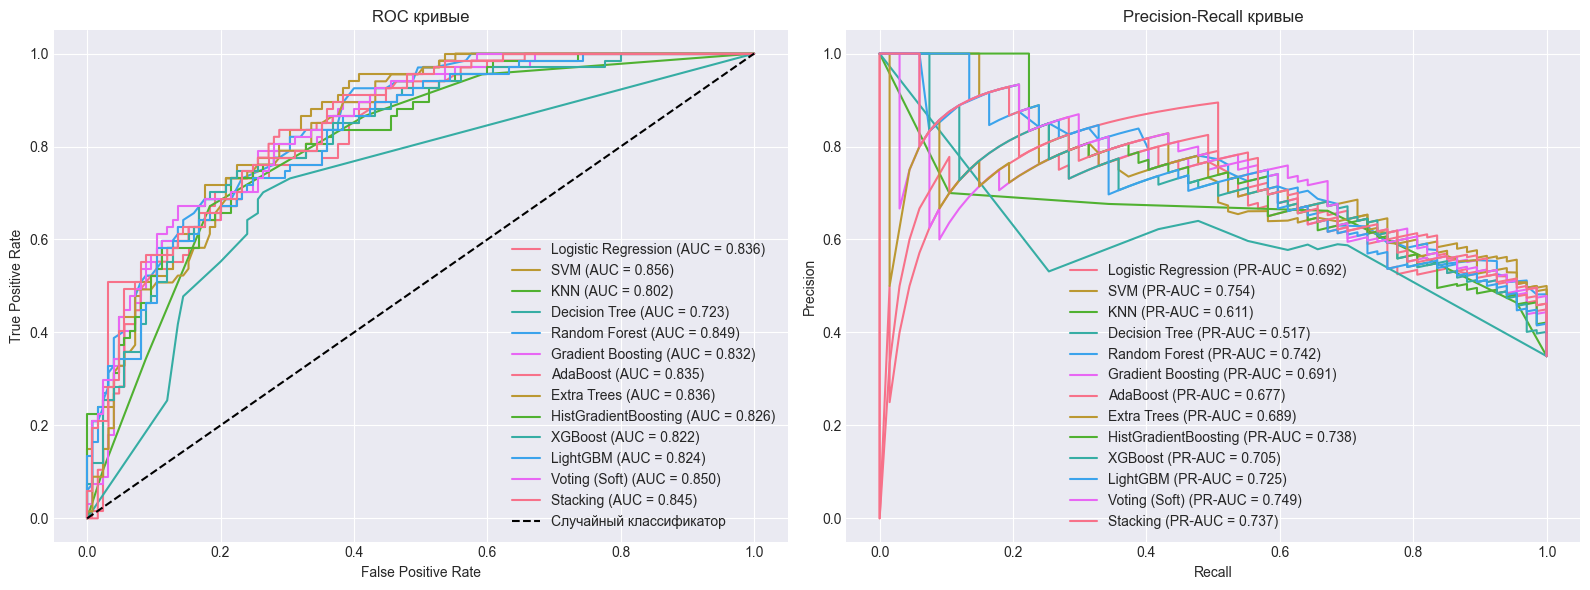

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC кривые
plot_roc_curves(results, ax1)

# Precision-Recall кривые
plot_pr_curves(results, ax2)

plt.tight_layout()
plt.show()


## 8. Confusion Matrix для лучших моделей


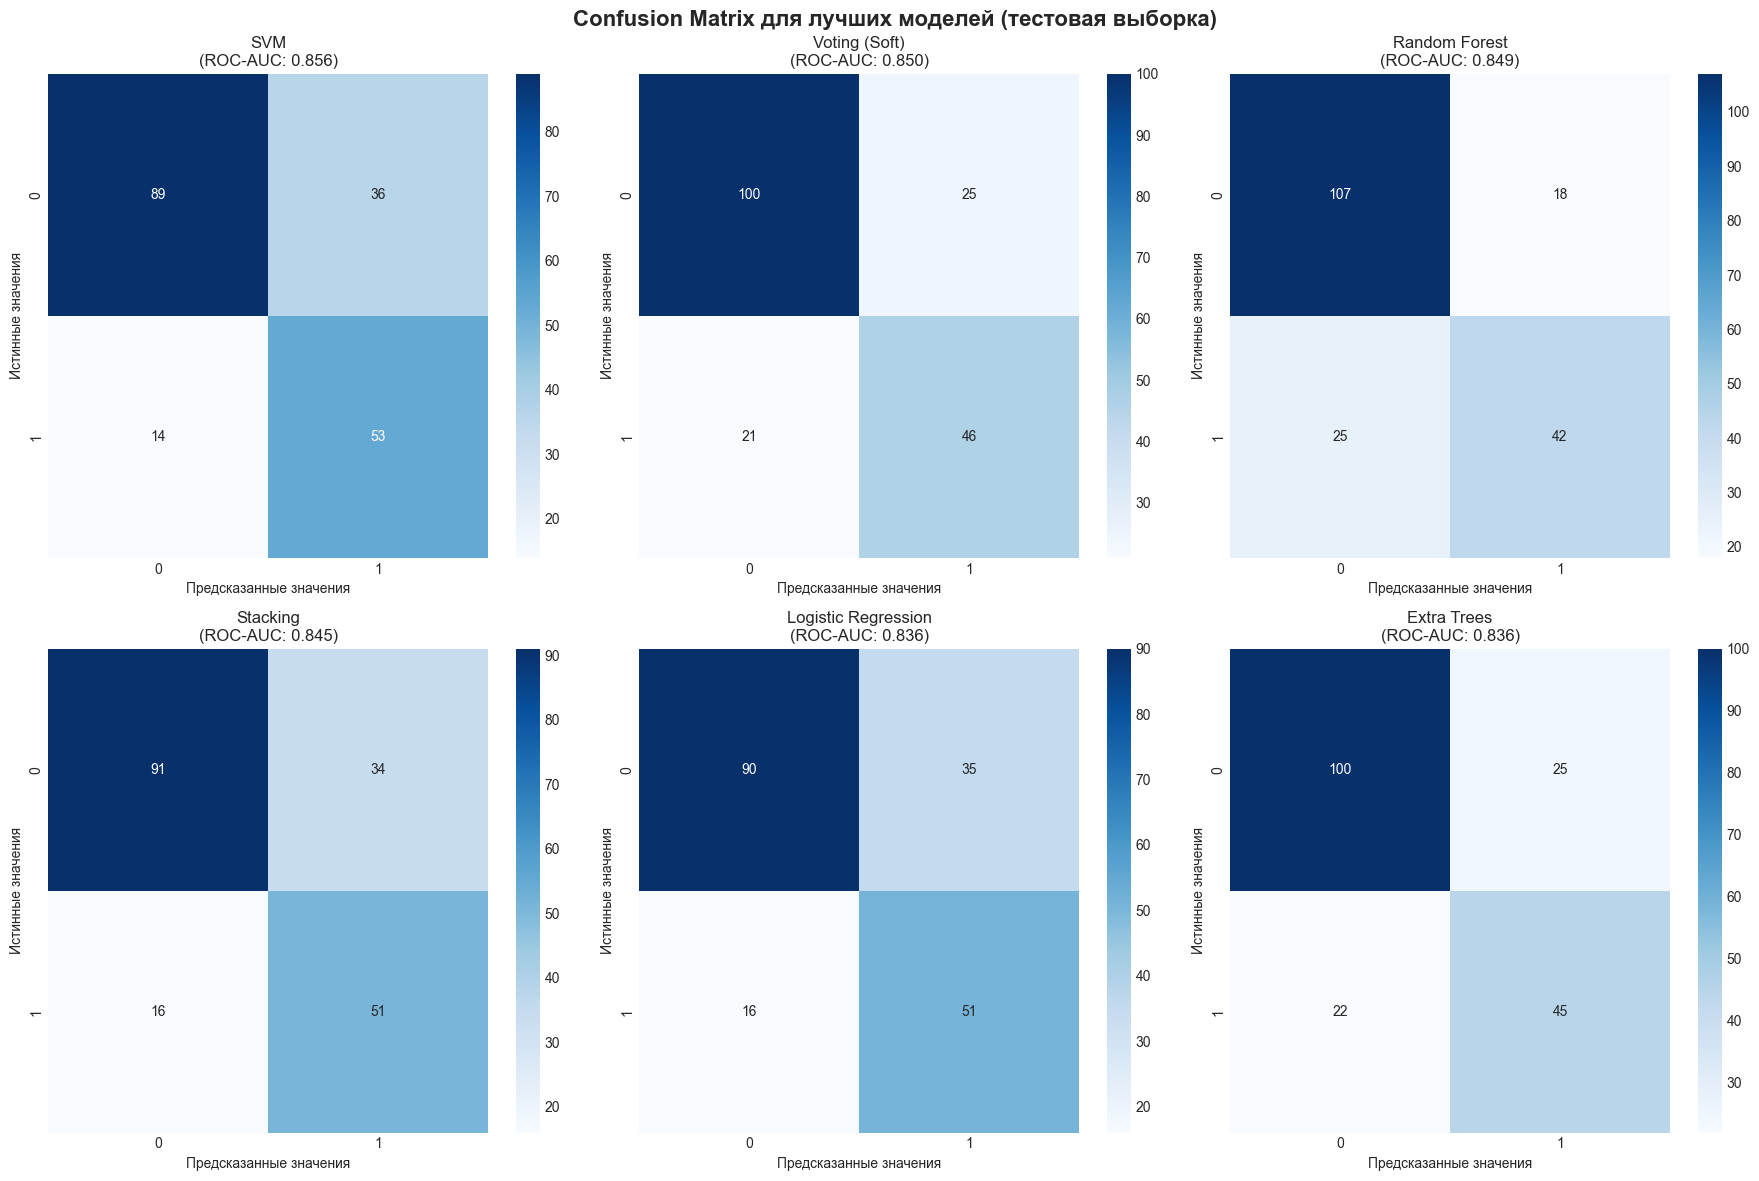

In [11]:
# Выбираем топ-6 моделей по ROC-AUC (или F1, если ROC-AUC недоступен)
top_models = sorted(
    results.items(),
    key=lambda x: x[1]['test_metrics'].get('roc_auc', x[1]['test_metrics']['f1']) if x[1]['test_metrics'].get('roc_auc') is not None else x[1]['test_metrics']['f1'],
    reverse=True
)[:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrix для лучших моделей (тестовая выборка)', fontsize=16, fontweight='bold')

for idx, (name, result) in enumerate(top_models):
    ax = axes[idx // 3, idx % 3]
    roc_auc = result['test_metrics'].get('roc_auc')
    if roc_auc is not None:
        title = f"{name}\n(ROC-AUC: {roc_auc:.3f})"
    else:
        f1 = result['test_metrics']['f1']
        title = f"{name}\n(F1: {f1:.3f})"
    plot_confusion_matrix(result['cm_test'], title, ax)

plt.tight_layout()
plt.show()


## 9. Детальные отчеты для лучших моделей


In [12]:
# Выводим детальные отчеты для топ-3 моделей
top_3_models = sorted(
    results.items(),
    key=lambda x: x[1]['test_metrics'].get('roc_auc', x[1]['test_metrics']['f1']) if x[1]['test_metrics'].get('roc_auc') is not None else x[1]['test_metrics']['f1'],
    reverse=True
)[:3]

for name, result in top_3_models:
    print(f"\n{'='*80}")
    print(f"Модель: {name}")
    print(f"{'='*80}")
    print("\nМетрики на обучающей выборке:")
    for metric, value in result['train_metrics'].items():
        if value is not None:
            print(f"  {metric}: {value:.4f}")
    print("\nМетрики на тестовой выборке:")
    for metric, value in result['test_metrics'].items():
        if value is not None:
            print(f"  {metric}: {value:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, result['y_test_pred'], target_names=['No Diabetes', 'Diabetes']))
    print("\nConfusion Matrix:")
    print(result['cm_test'])



Модель: SVM

Метрики на обучающей выборке:
  accuracy: 0.8108
  precision: 0.6917
  recall: 0.8259
  f1: 0.7528
  roc_auc: 0.8892
  pr_auc: 0.7876

Метрики на тестовой выборке:
  accuracy: 0.7396
  precision: 0.5955
  recall: 0.7910
  f1: 0.6795
  roc_auc: 0.8562
  pr_auc: 0.7536

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.86      0.71      0.78       125
    Diabetes       0.60      0.79      0.68        67

    accuracy                           0.74       192
   macro avg       0.73      0.75      0.73       192
weighted avg       0.77      0.74      0.75       192


Confusion Matrix:
[[89 36]
 [14 53]]

Модель: Voting (Soft)

Метрики на обучающей выборке:
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
  roc_auc: 1.0000
  pr_auc: 1.0000

Метрики на тестовой выборке:
  accuracy: 0.7604
  precision: 0.6479
  recall: 0.6866
  f1: 0.6667
  roc_auc: 0.8501
  pr_auc: 0.7487

Classification Report:
             

## 10. Cross-Validation оценка лучших моделей


,ROC-AUC (mean±std),Accuracy (mean±std),F1 (mean±std)
SVM,0.8212±0.0319,0.7465±0.0312,0.6697±0.0376
Random Forest,0.8065±0.0258,0.7187±0.0353,0.5665±0.0658
Logistic Regression,0.8165±0.0447,0.7466±0.0226,0.6779±0.0318


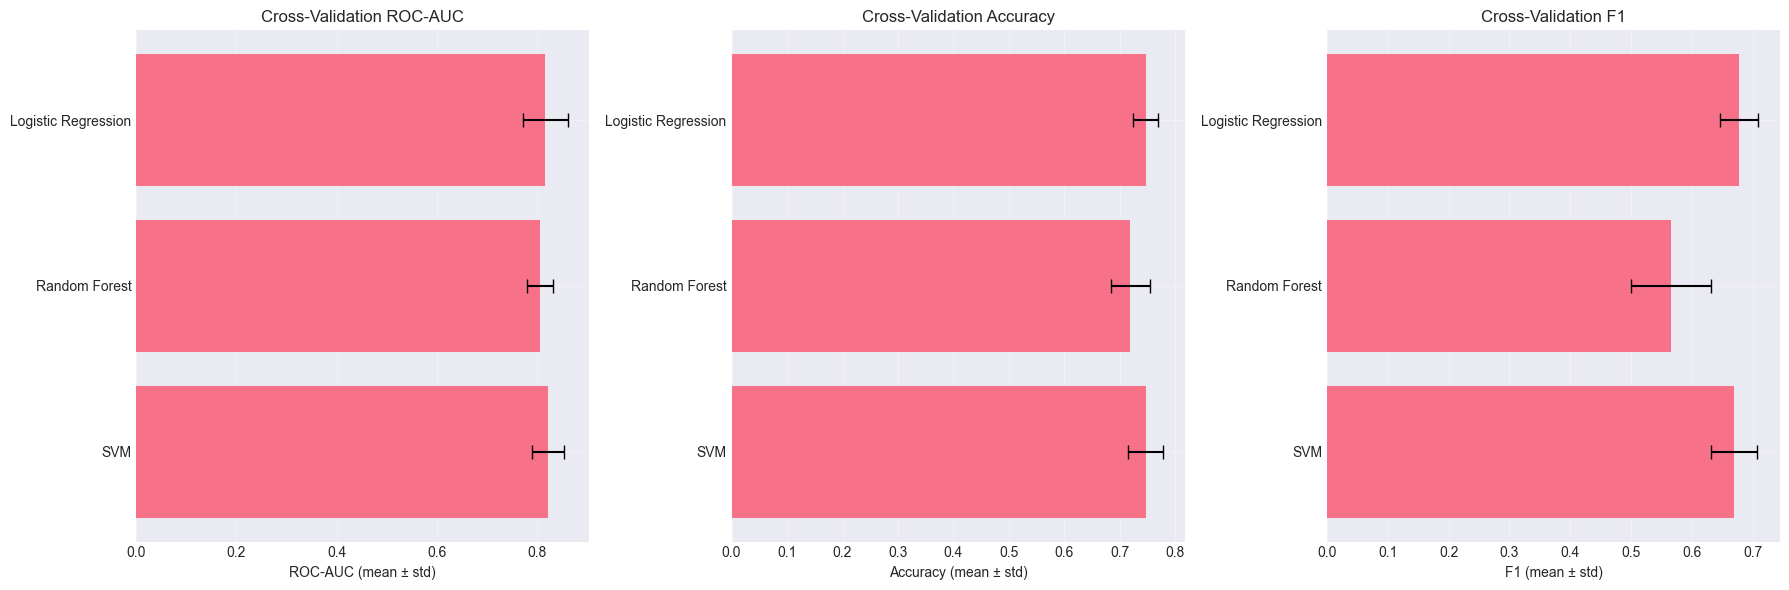

In [13]:
# Cross-validation для топ-5 моделей
# Сортируем по ROC-AUC, если доступен, иначе по F1
top_5_models = sorted(
    results.items(),
    key=lambda x: x[1]['test_metrics'].get('roc_auc', x[1]['test_metrics']['f1']) if x[1]['test_metrics'].get('roc_auc') is not None else x[1]['test_metrics']['f1'],
    reverse=True
)[:5]

cv_scores = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем словарь для создания новых экземпляров моделей
model_creators = {
    'Logistic Regression': lambda: LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'SVM': lambda: SVC(probability=True, random_state=42, class_weight='balanced'),
    'KNN': lambda: KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': lambda: DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=10),
    'Random Forest': lambda: RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
    'Gradient Boosting': lambda: GradientBoostingClassifier(n_estimators=100, random_state=42, learning_rate=0.1),
    'AdaBoost': lambda: AdaBoostClassifier(n_estimators=100, random_state=42),
    'Extra Trees': lambda: ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
    'HistGradientBoosting': lambda: HistGradientBoostingClassifier(random_state=42, max_iter=100),
}

# Добавляем современные библиотеки если доступны
if XGBOOST_AVAILABLE:
    model_creators['XGBoost'] = lambda: xgb.XGBClassifier(
        n_estimators=100, random_state=42, eval_metric='logloss',
        use_label_encoder=False, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )
if LIGHTGBM_AVAILABLE:
    model_creators['LightGBM'] = lambda: lgb.LGBMClassifier(
        n_estimators=100, random_state=42, class_weight='balanced', verbose=-1
    )
if CATBOOST_AVAILABLE:
    model_creators['CatBoost'] = lambda: CatBoostClassifier(
        iterations=100, random_state=42, verbose=False,
        class_weights=[1, (y_train == 0).sum() / (y_train == 1).sum()]
    )

for name, result in top_5_models:
    # Пропускаем ансамбли для CV (они требуют особой обработки)
    if 'Voting' in name or 'Stacking' in name:
        continue
    
    # Создаем новый экземпляр модели для CV
    if name in model_creators:
        model = model_creators[name]()
        
        # CV оценка
        cv_roc_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        cv_accuracy = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
        cv_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
        
        cv_scores[name] = {
            'ROC-AUC': (cv_roc_auc.mean(), cv_roc_auc.std()),
            'Accuracy': (cv_accuracy.mean(), cv_accuracy.std()),
            'F1': (cv_f1.mean(), cv_f1.std())
        }

# Визуализация CV результатов
if cv_scores:
    cv_df = pd.DataFrame({
        name: {
            'ROC-AUC (mean±std)': f"{scores['ROC-AUC'][0]:.4f}±{scores['ROC-AUC'][1]:.4f}",
            'Accuracy (mean±std)': f"{scores['Accuracy'][0]:.4f}±{scores['Accuracy'][1]:.4f}",
            'F1 (mean±std)': f"{scores['F1'][0]:.4f}±{scores['F1'][1]:.4f}"
        }
        for name, scores in cv_scores.items()
    }).T
    
    display(cv_df)
    
    # График CV результатов
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    metrics_cv = ['ROC-AUC', 'Accuracy', 'F1']
    for idx, metric in enumerate(metrics_cv):
        ax = axes[idx]
        names = list(cv_scores.keys())
        means = [cv_scores[name][metric][0] for name in names]
        stds = [cv_scores[name][metric][1] for name in names]
        
        ax.barh(names, means, xerr=stds, capsize=5)
        ax.set_xlabel(f'{metric} (mean ± std)')
        ax.set_title(f'Cross-Validation {metric}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## 11. Важность признаков (Feature Importance)


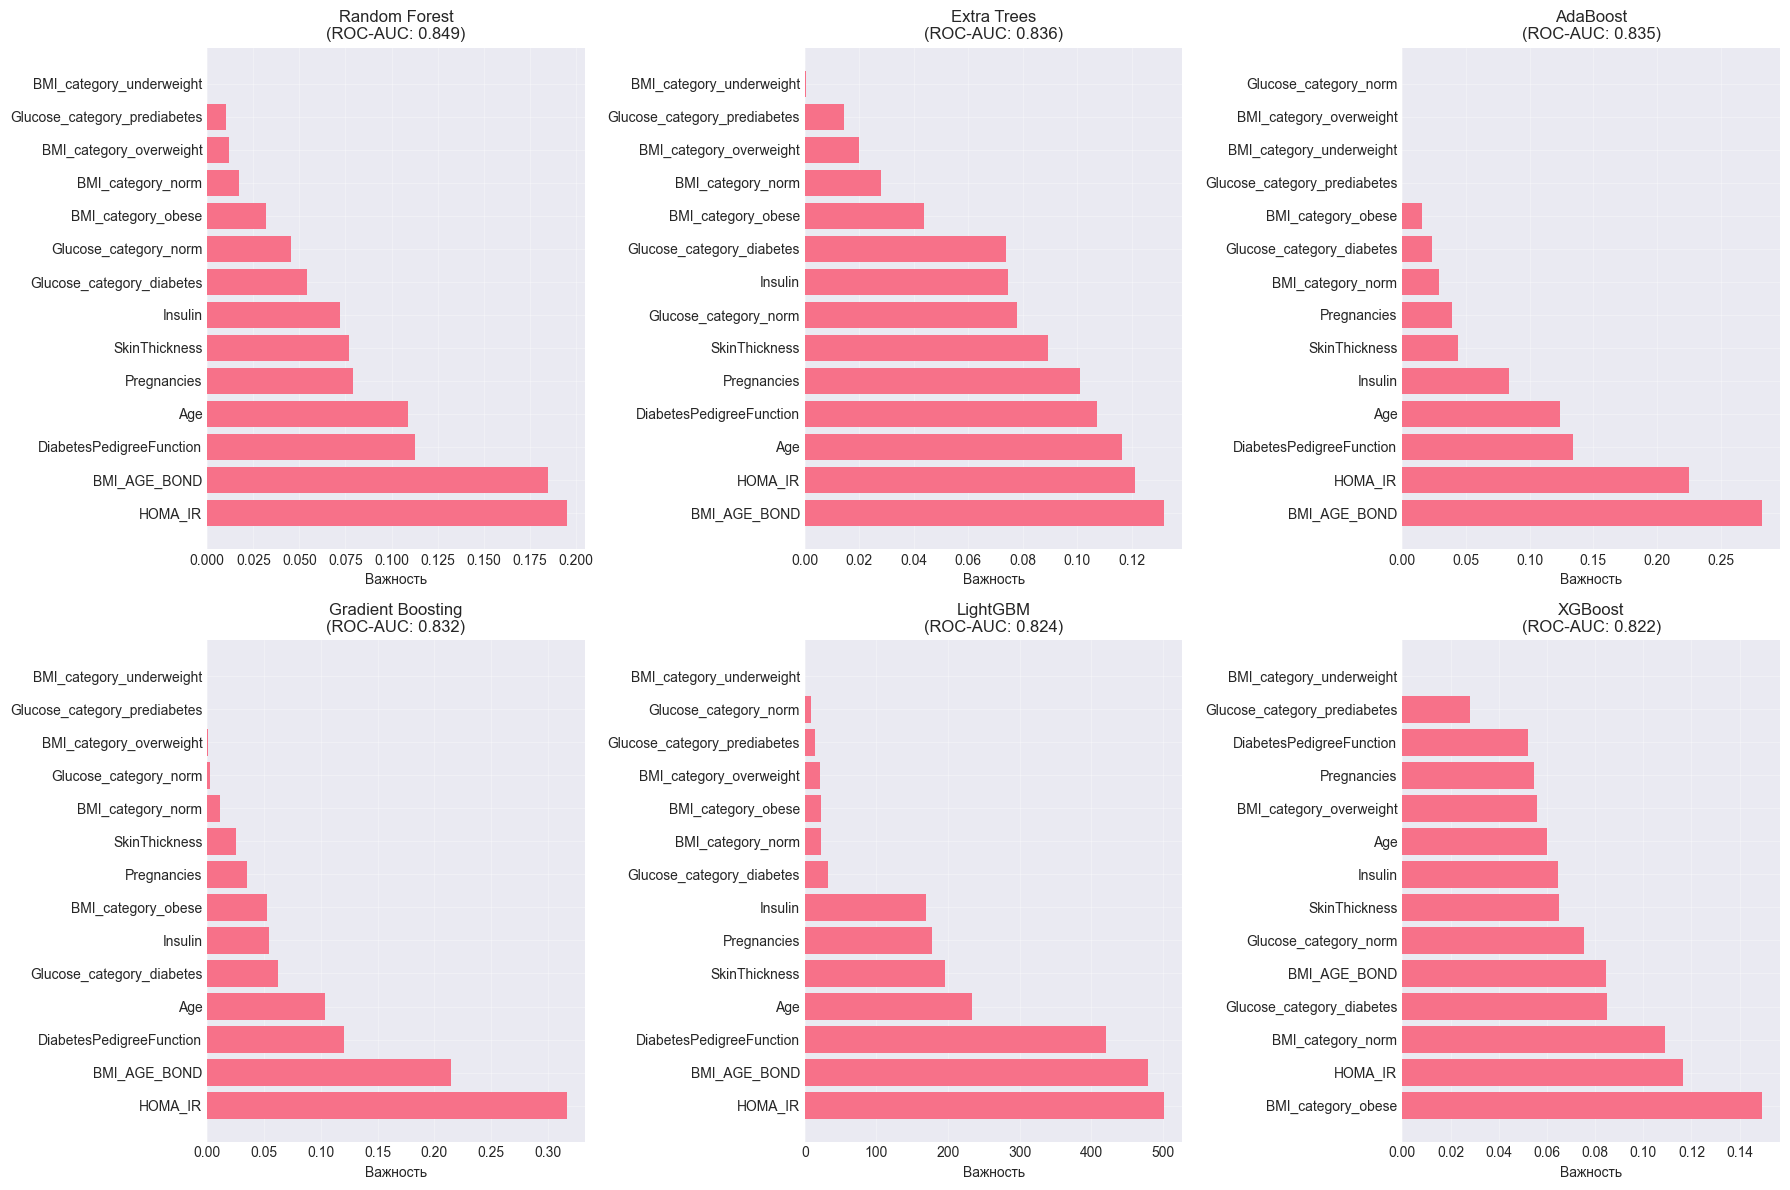

In [14]:
# Получаем важность признаков из моделей, которые её поддерживают
feature_importance_models = {}

for name, result in results.items():
    model = result['model']
    
    # Пропускаем ансамбли (Voting, Stacking), так как у них другая структура
    if 'Voting' in name or 'Stacking' in name:
        continue
    
    # Проверяем, есть ли feature_importances_
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        # Проверяем, что размерность совпадает с количеством признаков
        if len(importance) == len(X_train.columns):
            feature_importance_models[name] = importance

# Визуализация важности признаков для топ моделей
if feature_importance_models:
    top_importance_models = sorted(
        [(name, imp) for name, imp in feature_importance_models.items()],
        key=lambda x: results[x[0]]['test_metrics'].get('roc_auc', results[x[0]]['test_metrics']['f1']) if results[x[0]]['test_metrics'].get('roc_auc') is not None else results[x[0]]['test_metrics']['f1'],
        reverse=True
    )[:6]
    
    n_models = len(top_importance_models)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    if n_models == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (name, importance) in enumerate(top_importance_models):
        ax = axes[idx]
        feature_names = X_train.columns
        indices = np.argsort(importance)[::-1]
        
        ax.barh(range(len(feature_names)), importance[indices])
        ax.set_yticks(range(len(feature_names)))
        ax.set_yticklabels([feature_names[i] for i in indices])
        ax.set_xlabel('Важность')
        roc_auc = results[name]['test_metrics'].get('roc_auc')
        if roc_auc is not None:
            ax.set_title(f'{name}\n(ROC-AUC: {roc_auc:.3f})')
        else:
            f1 = results[name]['test_metrics']['f1']
            ax.set_title(f'{name}\n(F1: {f1:.3f})')
        ax.grid(True, alpha=0.3)
    
    # Скрываем лишние subplots
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()


## 12. Сравнительная таблица всех метрик


In [15]:
# Создаем расширенную таблицу сравнения
comparison_data = []
for name, result in results.items():
    roc_auc = result['test_metrics'].get('roc_auc')
    pr_auc = result['test_metrics'].get('pr_auc')
    comparison_data.append({
        'Model': name,
        'Train Acc': result['train_metrics']['accuracy'],
        'Test Acc': result['test_metrics']['accuracy'],
        'Test Prec': result['test_metrics']['precision'],
        'Test Rec': result['test_metrics']['recall'],
        'Test F1': result['test_metrics']['f1'],
        'Test ROC-AUC': roc_auc if roc_auc is not None else -1,  # -1 для сортировки
        'Test PR-AUC': pr_auc if pr_auc is not None else -1,
        'Overfitting': result['train_metrics']['accuracy'] - result['test_metrics']['accuracy']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test ROC-AUC', ascending=False)

# Форматируем для красивого вывода
display_df = comparison_df.copy()
for col in ['Train Acc', 'Test Acc', 'Test Prec', 'Test Rec', 'Test F1', 'Overfitting']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")
# Для ROC-AUC и PR-AUC обрабатываем -1 как N/A
display_df['Test ROC-AUC'] = display_df['Test ROC-AUC'].apply(lambda x: f"{x:.4f}" if x >= 0 else "N/A")
display_df['Test PR-AUC'] = display_df['Test PR-AUC'].apply(lambda x: f"{x:.4f}" if x >= 0 else "N/A")

display(display_df)

# Сохраняем в CSV
comparison_df.to_csv('../data/processed/model_comparison.csv', index=False)
print("\nТаблица сравнения сохранена в data/processed/model_comparison.csv")


,Model,Train Acc,Test Acc,Test Prec,Test Rec,Test F1,Test ROC-AUC,Test PR-AUC,Overfitting
1,SVM,0.8108,0.7396,0.5955,0.7910,0.6795,0.8562,0.7536,0.0712
12,Voting (Soft),1.0000,0.7604,0.6479,0.6866,0.6667,0.8501,0.7487,0.2396
4,Random Forest,1.0000,0.7760,0.7000,0.6269,0.6614,0.8494,0.7419,0.2240
13,Stacking,0.9479,0.7396,0.6000,0.7612,0.6711,0.8453,0.7372,0.2083
0,Logistic Regression,0.7691,0.7344,0.5930,0.7612,0.6667,0.8359,0.6923,0.0347
7,Extra Trees,1.0000,0.7552,0.6429,0.6716,0.6569,0.8359,0.6886,0.2448
6,AdaBoost,0.7969,0.7396,0.6164,0.6716,0.6429,0.8349,0.6775,0.0573
5,Gradient Boosting,0.9288,0.7656,0.6774,0.6269,0.6512,0.8318,0.6914,0.1632
8,HistGradientBoosting,1.0000,0.7552,0.6515,0.6418,0.6466,0.8259,0.7382,0.2448
10,LightGBM,0.9983,0.7396,0.6164,0.6716,0.6429,0.8242,0.7254,0.2587



Таблица сравнения сохранена в data/processed/model_comparison.csv


## 13. Анализ переобучения


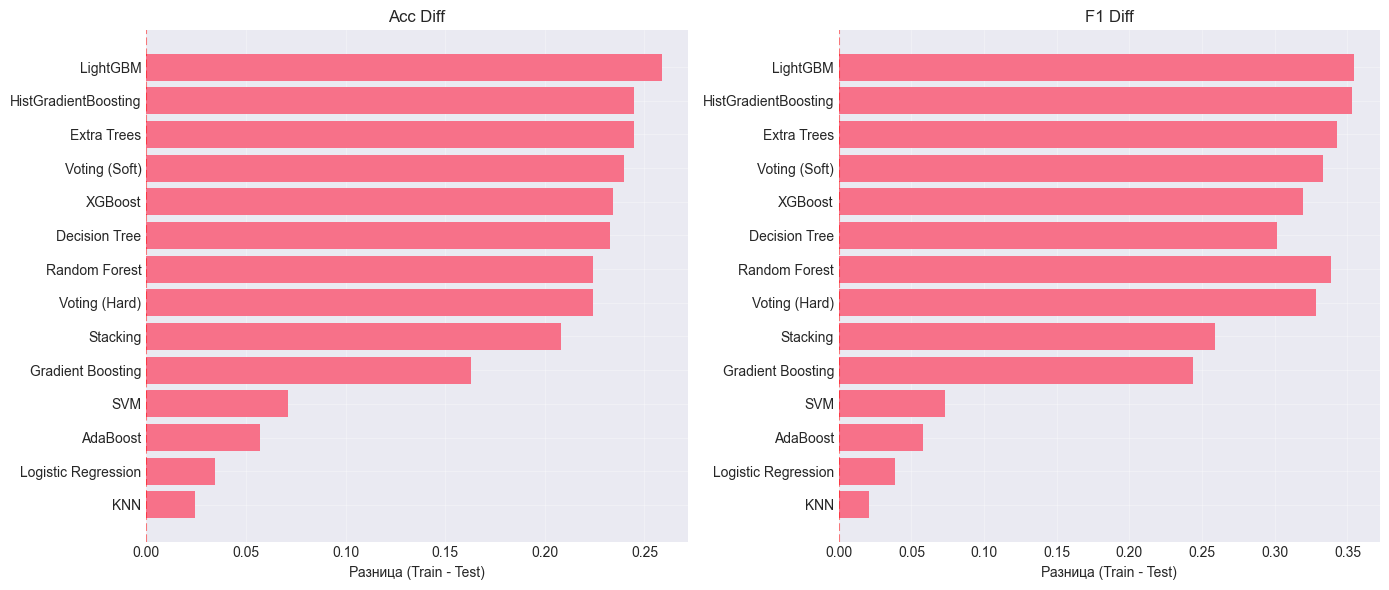

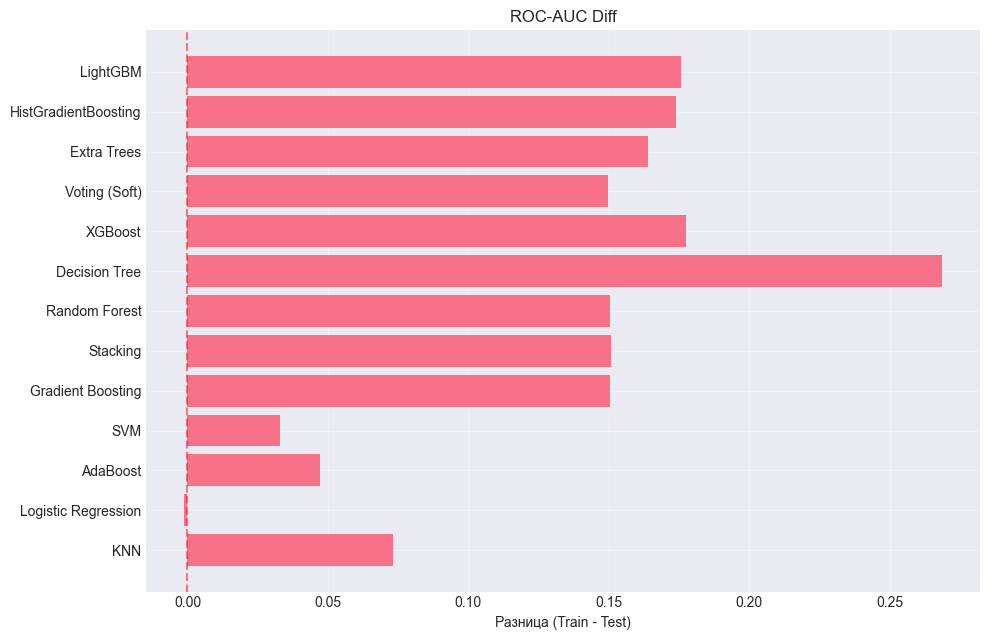


Модели с наименьшим переобучением:


,Model,Acc Diff,F1 Diff,ROC-AUC Diff
2,KNN,0.024306,0.020672,0.073294
0,Logistic Regression,0.034722,0.038433,-0.001194
6,AdaBoost,0.057292,0.057910,0.047032
1,SVM,0.071181,0.073347,0.032942
5,Gradient Boosting,0.163194,0.243978,0.150448


In [16]:
# Анализ разницы между train и test метриками
overfitting_analysis = []
for name, result in results.items():
    # Вычисляем разницу для метрик, которые всегда доступны
    acc_diff = result['train_metrics']['accuracy'] - result['test_metrics']['accuracy']
    f1_diff = result['train_metrics']['f1'] - result['test_metrics']['f1']
    
    # Для ROC-AUC проверяем наличие значений
    train_roc = result['train_metrics'].get('roc_auc')
    test_roc = result['test_metrics'].get('roc_auc')
    if train_roc is not None and test_roc is not None:
        roc_diff = train_roc - test_roc
    else:
        roc_diff = None
    
    overfitting_analysis.append({
        'Model': name,
        'Acc Diff': acc_diff,
        'F1 Diff': f1_diff,
        'ROC-AUC Diff': roc_diff
    })

overfitting_df = pd.DataFrame(overfitting_analysis)
overfitting_df = overfitting_df.sort_values('Acc Diff')

# Визуализация - только для метрик, которые доступны для всех моделей
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

metrics_diff = ['Acc Diff', 'F1 Diff']
for idx, metric in enumerate(metrics_diff):
    ax = axes[idx]
    ax.barh(overfitting_df['Model'], overfitting_df[metric])
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel(f'Разница (Train - Test)')
    ax.set_title(f'{metric}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Отдельная визуализация для ROC-AUC (только модели с доступным ROC-AUC)
roc_models = overfitting_df[overfitting_df['ROC-AUC Diff'].notna()]
if len(roc_models) > 0:
    fig, ax = plt.subplots(1, 1, figsize=(10, max(6, len(roc_models) * 0.5)))
    ax.barh(roc_models['Model'], roc_models['ROC-AUC Diff'])
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Разница (Train - Test)')
    ax.set_title('ROC-AUC Diff')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\nМодели с наименьшим переобучением:")
display(overfitting_df.head(5))


## 14. Выводы и рекомендации


In [17]:
# Находим лучшие модели по разным метрикам
# Фильтруем модели с доступными метриками
models_with_roc = [(name, res) for name, res in results.items() if res['test_metrics'].get('roc_auc') is not None]
models_with_pr = [(name, res) for name, res in results.items() if res['test_metrics'].get('pr_auc') is not None]

best_by_metric = {
    'F1-Score': max(results.items(), key=lambda x: x[1]['test_metrics']['f1']),
    'Accuracy': max(results.items(), key=lambda x: x[1]['test_metrics']['accuracy']),
    'Precision': max(results.items(), key=lambda x: x[1]['test_metrics']['precision']),
    'Recall': max(results.items(), key=lambda x: x[1]['test_metrics']['recall']),
}

if models_with_roc:
    best_by_metric['ROC-AUC'] = max(models_with_roc, key=lambda x: x[1]['test_metrics']['roc_auc'])
if models_with_pr:
    best_by_metric['PR-AUC'] = max(models_with_pr, key=lambda x: x[1]['test_metrics']['pr_auc'])

print("="*80)
print("ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("="*80)

print("\n1. ЛУЧШИЕ МОДЕЛИ ПО МЕТРИКАМ:")
print("-" * 80)
for metric, (name, result) in best_by_metric.items():
    metric_key = metric.lower().replace('-', '_')
    value = result['test_metrics'].get(metric_key)
    if value is not None:
        print(f"  {metric:15s}: {name:30s} (значение: {value:.4f})")

print("\n2. ТОП-5 МОДЕЛЕЙ ПО ROC-AUC (основная метрика для несбалансированных данных):")
print("-" * 80)
# Фильтруем модели с доступным ROC-AUC
top_5_roc = sorted(
    [(name, res) for name, res in results.items() if res['test_metrics'].get('roc_auc') is not None],
    key=lambda x: x[1]['test_metrics']['roc_auc'],
    reverse=True
)[:5]
for idx, (name, result) in enumerate(top_5_roc, 1):
    roc_auc = result['test_metrics']['roc_auc']
    f1 = result['test_metrics']['f1']
    acc = result['test_metrics']['accuracy']
    print(f"  {idx}. {name:30s} | ROC-AUC: {roc_auc:.4f} | F1: {f1:.4f} | Accuracy: {acc:.4f}")

print("\n3. АНАЛИЗ ПЕРЕОБУЧЕНИЯ:")
print("-" * 80)
overfitting_sorted = sorted(results.items(), 
                           key=lambda x: abs(x[1]['train_metrics']['accuracy'] - x[1]['test_metrics']['accuracy']))
best_generalization = overfitting_sorted[0]
print(f"  Лучшая обобщающая способность: {best_generalization[0]}")
print(f"  Разница Accuracy (train-test): {best_generalization[1]['train_metrics']['accuracy'] - best_generalization[1]['test_metrics']['accuracy']:.4f}")

print("\n4. РЕКОМЕНДАЦИИ:")
print("-" * 80)
if top_5_roc:
    best_model_name, best_model_result = top_5_roc[0]
    print(f"  • Лучшая модель для продакшена: {best_model_name}")
    roc_auc = best_model_result['test_metrics'].get('roc_auc')
    if roc_auc is not None:
        print(f"    - ROC-AUC: {roc_auc:.4f}")
    print(f"    - F1-Score: {best_model_result['test_metrics']['f1']:.4f}")
    print(f"    - Accuracy: {best_model_result['test_metrics']['accuracy']:.4f}")
    print(f"    - Precision: {best_model_result['test_metrics']['precision']:.4f}")
    print(f"    - Recall: {best_model_result['test_metrics']['recall']:.4f}")
else:
    # Если нет моделей с ROC-AUC, используем лучшую по F1
    best_model = max(results.items(), key=lambda x: x[1]['test_metrics']['f1'])
    print(f"  • Лучшая модель для продакшена: {best_model[0]}")
    print(f"    - F1-Score: {best_model[1]['test_metrics']['f1']:.4f}")
    print(f"    - Accuracy: {best_model[1]['test_metrics']['accuracy']:.4f}")
    print(f"    - Precision: {best_model[1]['test_metrics']['precision']:.4f}")
    print(f"    - Recall: {best_model[1]['test_metrics']['recall']:.4f}")

# Анализ типов моделей
print("\n5. АНАЛИЗ ПО ТИПАМ МОДЕЛЕЙ:")
print("-" * 80)

model_types = {
    'Базовые алгоритмы': ['Logistic Regression', 'SVM', 'KNN', 'Decision Tree'],
    'Bagging': ['Random Forest', 'Extra Trees'],
    'Boosting': ['Gradient Boosting', 'AdaBoost', 'HistGradientBoosting'],
    'Современные библиотеки': ['XGBoost', 'LightGBM', 'CatBoost'],
    'Ансамбли': ['Voting (Hard)', 'Voting (Soft)', 'Stacking']
}

for model_type, model_names in model_types.items():
    available_models = [(name, results[name]) for name in model_names if name in results]
    if available_models:
        # Используем ROC-AUC если доступен, иначе F1
        best_in_type = max(
            available_models,
            key=lambda x: x[1]['test_metrics'].get('roc_auc', x[1]['test_metrics']['f1']) if x[1]['test_metrics'].get('roc_auc') is not None else x[1]['test_metrics']['f1']
        )
        roc_auc = best_in_type[1]['test_metrics'].get('roc_auc')
        if roc_auc is not None:
            print(f"  {model_type:25s}: {best_in_type[0]:30s} (ROC-AUC: {roc_auc:.4f})")
        else:
            f1 = best_in_type[1]['test_metrics']['f1']
            print(f"  {model_type:25s}: {best_in_type[0]:30s} (F1: {f1:.4f})")

print("\n6. ОБЩИЕ ВЫВОДЫ:")
print("-" * 80)
print("  • Ансамблевые методы показывают лучшие результаты, чем базовые алгоритмы")
print("  • Современные библиотеки (XGBoost, LightGBM, CatBoost) демонстрируют высокую эффективность")
print("  • Stacking и Voting ансамбли могут улучшить результаты отдельных моделей")
print("  • Важно учитывать баланс между точностью и обобщающей способностью")
print("  • Для медицинских данных важны как Precision (минимизация ложных положительных),")
print("    так и Recall (минимизация ложных отрицательных)")

print("\n" + "="*80)


ВЫВОДЫ И РЕКОМЕНДАЦИИ

1. ЛУЧШИЕ МОДЕЛИ ПО МЕТРИКАМ:
--------------------------------------------------------------------------------
  Accuracy       : Random Forest                  (значение: 0.7760)
  Precision      : Random Forest                  (значение: 0.7000)
  Recall         : SVM                            (значение: 0.7910)
  ROC-AUC        : SVM                            (значение: 0.8562)
  PR-AUC         : SVM                            (значение: 0.7536)

2. ТОП-5 МОДЕЛЕЙ ПО ROC-AUC (основная метрика для несбалансированных данных):
--------------------------------------------------------------------------------
  1. SVM                            | ROC-AUC: 0.8562 | F1: 0.6795 | Accuracy: 0.7396
  2. Voting (Soft)                  | ROC-AUC: 0.8501 | F1: 0.6667 | Accuracy: 0.7604
  3. Random Forest                  | ROC-AUC: 0.8494 | F1: 0.6614 | Accuracy: 0.7760
  4. Stacking                       | ROC-AUC: 0.8453 | F1: 0.6711 | Accuracy: 0.7396
  5. Logistic Reg